# Table of contents
<a id='toc'></a>
- [Initialisation](#init)
- [Preliminaries](#data)
- [Task 1: Random Forest Classifier](#cls)
- [Task 2: Support Vector Machine Classifier](#svm)
- [Task 3: Neural Network](#net)
- [Task 4: Discussion](#dis)

# Initialisation
<a id='init'></a>

In [0]:
!pip install skorch

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from scipy.stats import uniform, expon
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.tree import export_graphviz
import pydotplus
from skorch import NeuralNetClassifier
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix



# Preliminaries
<a id='data'></a>

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_csv("/content/drive/My Drive/Courswork2/train_set.csv")
test = pd.read_csv("/content/drive/My Drive/Courswork2/test_set(1).csv")

In [0]:
train=train.drop('Unnamed: 0',axis=1)
test=test.drop('Unnamed: 0',axis=1)

In [0]:
replacements={'rating':{'good':2,'unacc':0,'vgood':3,'acc':1},
              'buying':{'low':0,'med':1,'vhigh':3,'high':2},
              'maint':{'low':0,'med':1,'vhigh':3,'high':2},
              'doors':{'2':0,'3':1,'4':2,'5more':3},
              'lug_boot':{'small':0,'med':1,'big':2},
              'safety':{'low':0,'med':1,'high':2},
              'persons':{'2':0,'4':1,'more':2}}
train=train.replace(replacements)
test=test.replace(replacements)

In [0]:
X_train=train.drop('rating',axis=1)
Y_train=train['rating']
X_test=test.drop('rating',axis=1)
Y_test=test['rating']

In [0]:
scaler= StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)


Scaling plays a significant role as we would not want our instances to be on different scales. We use StandardScaler which shifts the data so that it has mean 0 and variance 1. SVM Classifier is one of the models that requires scaling so that the decision boundary to be better chosen. On the other hand, Random Forest is not very sensitive to scaling, but we will keep the values scaled for better accuracy.

When tuning the hyperparameters of our models, we are going to do it one parameter at a time as the computational time increases massively for multiple parameters. It is not going to be the optimal combination of parameters, but we will make the assumption that it is close enough to the values as if we would have done Grid Search on all of them at once.

[back to top](#toc)


# Task 1: Random Forest Classifier
<a id='cls'></a>

__Random Forest__ is an ensemble of __Decision Trees__ trained through the bagging method. The bagging method involves training the same model - Decision Tree - on different random samples from the training. The sampling is done with replacement and for each decision tree, only a subset of the entire feature spectrum is chosen. The prediction is made by aggregating all the predictions from the models through statistical means such as frequency. 

Random Forest has a couple of hyperparameters which we will need to optimise. We will use GridSearchCV which will perform a __Stratified 5-Fold__ cross-validition to find the best parameter. We will tune 'n_estimators', 'max_depth' and 'max_features'. Performing a GridSearchCV for all 3 parameters all at once requires substantial computational power, therefore we will perform GridSearchCV one parameter at a time. We will use 'accuracy' as a score inside the GridSearchCV.

In [0]:
#initialise the Random Forest Classifier
#set up the n_jobs=-1 to use all the processors when running the trees in parallel
rfmodel=RandomForestClassifier(n_jobs=-1)


In [0]:
#initialise the Stratified KFold for the GridSearchCV with 5 splits
stf=StratifiedKFold(n_splits=5)

We will start with finding the best 'n_estimators' hyperparameter for our data. 'N_estimators' defines the number of Decision Trees are going to be used in the ensemble method. 

In [0]:
no_trees=[int(x) for x in np.linspace(20,1200,60)] #list of values for the n_estimators that the GridSearchCV will go through to select the best parameter
parameters={'n_estimators':no_trees}#initialise the dictionary for the GridSearchCV
grid_search=GridSearchCV(estimator=rfmodel,param_grid=parameters,scoring='accuracy',cv=stf)


In [0]:
#fit the GridSearchCV to the data and print the best parameter found from our list
grid_search.fit(X_train,Y_train.values)
print(grid_search.best_params_)

{'n_estimators': 180}


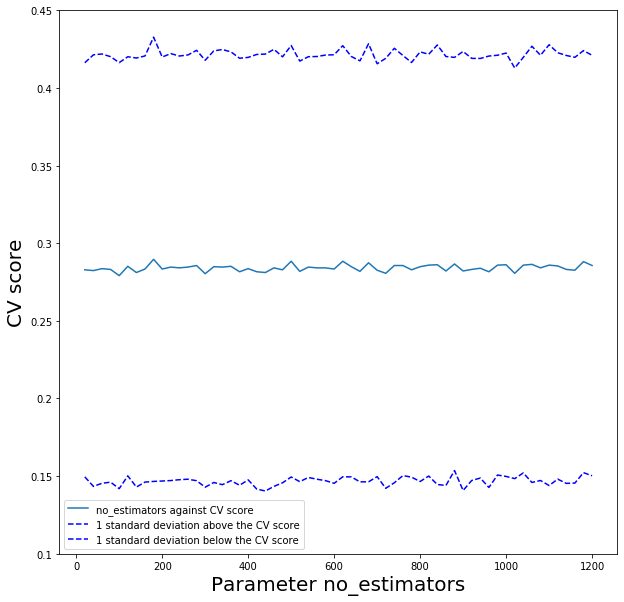

In [0]:
#plot the values of n_estimators against the CV score
no_trees= grid_search.cv_results_['param_n_estimators'].data
scores = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(no_trees, scores,label='no_estimators against CV score')
plt.plot(no_trees, np.array(scores) + np.array(scores_std), 'b--',label='1 standard deviation above the CV score')
plt.plot(no_trees, np.array(scores) - np.array(scores_std), 'b--', label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter no_estimators',fontsize=20)
plt.legend()
plt.show()

Based on our data, we can see that the best number of Decision Trees is 180 with a CV score of around 0.3. I have plotted the paramater against the CV score, the blue line, and I have also included the confidence interval by plotting the CV score 1 standard deviation above and below the CV score. We can see that the score oscillates but remains in the same range. We will keep this 180 as our best value and we will move on to the next hyperparameter.

After choosing the best number of Decision Trees, we will move on to 'max_features'. 'Max_features' defines the number of features that is going be randomly selected for each Decision Tree. It is one of the most important features as it assures that the model would not overfit. 

In [0]:
rfmodel=RandomForestClassifier(n_jobs=-1,n_estimators=180)#set up the Random Forest Classifier model with the best values for n_estimators
max_features=[2,3,4,5]#set up a list of values for max_features; as we only have 6 features, our maximum value will be 5
parameters={'max_features':max_features}#initialise the dictionary for the GridSearchCv
grid_search=GridSearchCV(estimator=rfmodel,param_grid=parameters,scoring='accuracy',cv=stf)

In [0]:
#fit the GridSearchCV to our data and print the best value for the hyperparameter
grid_search.fit(X_train,Y_train.values)
print(grid_search.best_params_)

{'max_features': 4}


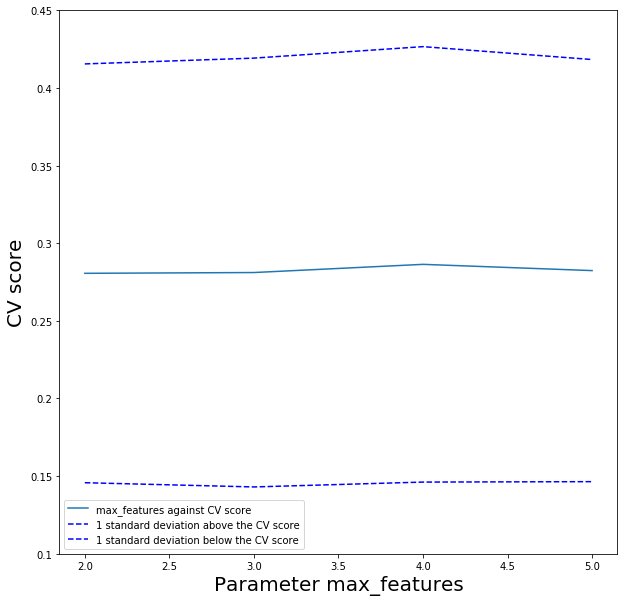

In [0]:
#plot the values of max_features against the CV score
max_features= grid_search.cv_results_['param_max_features'].data
scores = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(max_features, scores, label='max_features against CV score')
plt.plot(max_features, np.array(scores) + np.array(scores_std), 'b--',label='1 standard deviation above the CV score')
plt.plot(max_features, np.array(scores) - np.array(scores_std), 'b--',label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter max_features',fontsize=20)
plt.legend()
plt.show()

Based on our data, we can see that the best number of 'max_features' is 4 with a CV score of around 0.3. I have plotted the paramater against the CV score, the blue line, and I have also included the confidence interval by plotting the CV score 1 standard deviation above and below the CV score. We can see that the CV score remains quite constant, with a small peak at 3 which can be observed from the dotted line. Therefore, based on the fact that we are modelling 180 Decision Trees, we should select at random 3 features for each Decision Tree. This is understandable as the maximum number of features we have is 6 and usually it has been proven that the optimal number of features should be sqrt of the entire feature space cardinal. 

After choosing both 'max_features' and 'n_estimators', we will move on to 'max_depth'. 'Max_depth' defines the number of decision boundaries of each Decision Tree.

In [0]:
rfmodel=RandomForestClassifier(n_jobs=-1,n_estimators=180,max_features=4)#initialise the Random Forest Classifier with the best values 
#for n_estimators and max_features
depth_trees=[3,4,5,6,7,8,9]#set up the list for the max_depth
parameters={'max_depth':depth_trees}#set up the dictionary for the GridSearchCV
grid_search=GridSearchCV(estimator=rfmodel,param_grid=parameters,scoring='accuracy',cv=stf)

In [0]:
#fit the GridSearchCV to our datta and print the best value for max_depth
grid_search.fit(X_train,Y_train.values)
print(grid_search.best_params_)

{'max_depth': 5}


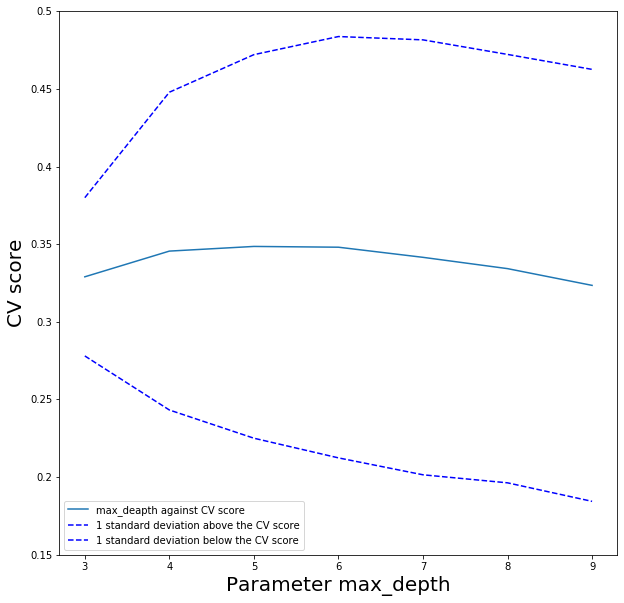

In [0]:
#plot the values of max_depth against the CV score
depth_trees= grid_search.cv_results_['param_max_depth'].data
scores = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(depth_trees, scores,label='max_deapth against CV score')
plt.plot(depth_trees, np.array(scores) + np.array(scores_std), 'b--',label='1 standard deviation above the CV score')
plt.plot(depth_trees, np.array(scores) - np.array(scores_std), 'b--',label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter max_depth',fontsize=20)
plt.legend()
plt.show()

Based on our data, we can see that the best number of 'max_depth' is 5 with a CV score of around 0.35. I have plotted the paramater against the CV score, the blue line, and I have also included the confidence interval by plotting the CV score 1 standard deviation above and below the CV score. We can clearly see the peak at 0.35 and then it starts to descend. Considering that we are using just 4 features at random for each Decision Tree, we would not need a complex tree with multiple decision boundaries that will not eventually be able to extract just the proper information. 

In [0]:
#initialise the final version of the model with the hyperparameters chosen so far
rfmodel_final=RandomForestClassifier(n_estimators=180,max_depth=5,max_features=4,n_jobs=-1,oob_score=True)
rfmodel_final.fit(X_train,Y_train.values)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

As the Random Forest Classifier samples with replacement, there are going to be instances that we not going to be trained on and we can evaluate our model using them. This is called  __Out-of-Bag Evaluation__. The score is calculated based on the accuracy.

In [0]:
rfmodel_final.oob_score_


0.3994483450351053

In [0]:
rfmodel_final.oob_decision_function_

array([[0.21566382, 0.25475658, 0.27277532, 0.25680428],
       [0.31114961, 0.16973493, 0.2215326 , 0.29758286],
       [0.20415186, 0.25467854, 0.25279582, 0.28837378],
       ...,
       [0.9790494 , 0.00701295, 0.00646919, 0.00746846],
       [0.98857345, 0.00332167, 0.00419269, 0.00391219],
       [0.98843953, 0.00358337, 0.00353272, 0.00444439]])

By calling the oob_decision_function_ we can see the probabilities of belonging to a classes and as we can see the model finds it hard to completely distinguish between classes with perfect probability.

Therefore, our accuracy for this model is 0.4. As a proof of concept, I am going to show an image of the 100th Decision Tree in our Random Forest. This is not the whole picture as each Decision Tree will have a different structure. 

In [0]:
estimator=rfmodel_final.estimators_[100]
dot_data=export_graphviz(estimator, out_file=None, 
                feature_names = train.drop('rating',axis=1).columns,
                class_names = ['unacc','acc','good','vgood'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"15,30!"')
pydot_graph.write_png('resized_tree20.png')

True

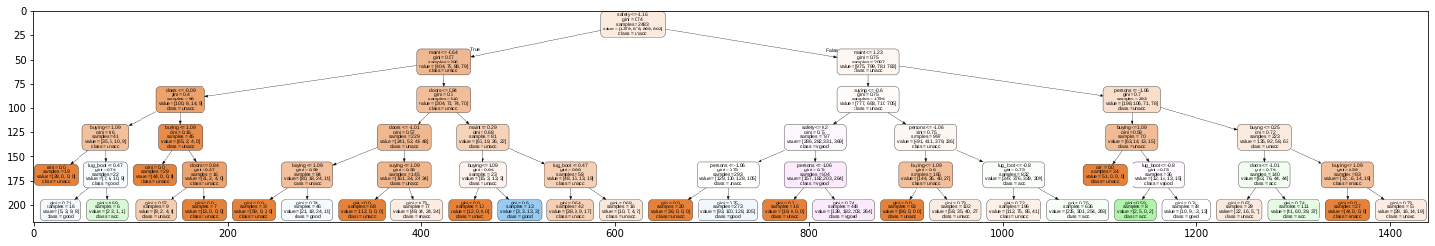

In [0]:
img=mpimg.imread('resized_tree20.png')
plt.figure(figsize=(25,25))
plt.imshow(img)

As we can see, we have 5 decision boundaries. As expected, as our data set class is unbalanced containing most of the instances from the 'unacc' class  35%, most of the nodes tend to decide for 'unacc'. Therefore, the model is performing poorly for all the other classes except 'unacc'. 

In [0]:
features_importance=pd.DataFrame(rfmodel_final.feature_importances_,
                                   index = train.drop('rating',axis=1).columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

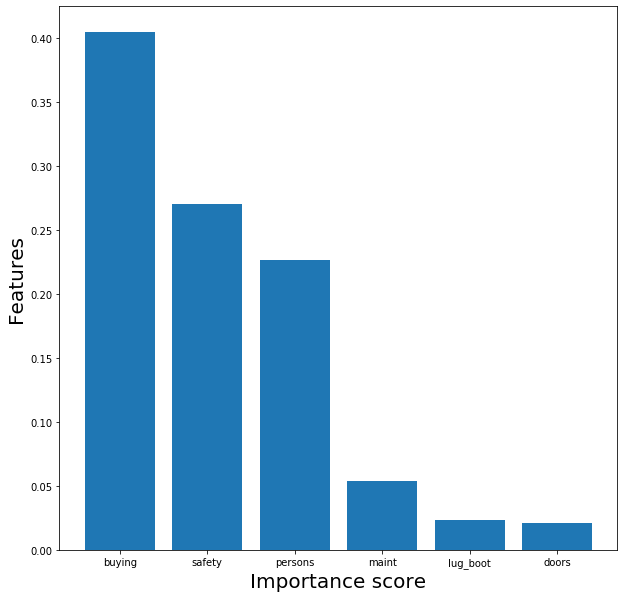

In [0]:
x = features_importance.index
y = features_importance.iloc[:, 0]
plt.figure(figsize=(10,10))
plt.bar(x,y)
plt.ylabel('Features',fontsize=20)
plt.xlabel('Importance score',fontsize=20)
plt.show()

I have plotted the importance score of our features. From the plot, we can see that 'buying','safety','persons' contribute the most to the rating. This can also be seen from our image of the tree where 'lug_boot' and 'doors' is mostly used at the end of tree.

[back to top](#toc)

#Task 2: Support Vector Machine Classifier
<a id='svm'></a>

An SVM Classifier is fitting the widest street possible between the classes. As we have a multiclass classification problem, we will use as the predefined decision_function shape='ovr' which means 'One-vs-Rest'. This strategy involves training one binary classifier for each class and we select the highest decision score. If we impose that we keep all instances off the street, then we assume that they are linearly separable, however this is rarely true in real life. This applies to our dataset as well, as seen in the Random Forest case. That is why we need to find a balance between keeping the street as large as possible and making less margin violations. We can control this using the C hyperparameter. A larger C, will mean fewer margin violations but smaller street which can lead to overfitting as it will find it hard to generalise (low bias, high variance). A smaller C, will mean more margin violations but larger street (high bias, low variance). However, those margin violations could be on the right side of the street and the model will still perform better. Theoretically, our optimisation problem reduces to $$min \left(\frac{\mid\mid\beta\mid\mid^{2}}{2}+C\sum_{i=1}^{N}\xi_{i}\right)$$ subject to  $\xi_{i}\geq0,y_{i}(x_{i}^{T}\beta+\beta_{0})\geq1-\xi_{i}$ where $\xi_{i}$ represents the proportional amount by which the prediction $f(x_{i})=x_{i}^{T}\beta+\beta_{0}$ is on the wrong side of its margin and $\mid\mid\beta\mid\mid$ is the slope of the function f . Essentially, we can also think of C as $\sum_{i=1}^{N}\xi_{i}\leq C $.

We will perform the same GridSearchCV as before to tune the hyperparameters.

#### Linear Support Vector Machine

In [0]:
svmcls=SVC(kernel='linear',random_state=42)#initialise the SVM with linear kernel 

In [0]:
C=[int(x) for x in np.linspace(1,120,40)]#list of values for the parameter C
params={'C':C}#set up the dictionary for the GridSearchCV
clf=GridSearchCV(estimator=svmcls,param_grid=params,scoring='accuracy',cv=stf)

In [0]:
#fit GridSearchCV to our data and print the best value of the parameter
clf.fit(X_train,Y_train.values)
print(clf.best_params_)

{'C': 86}


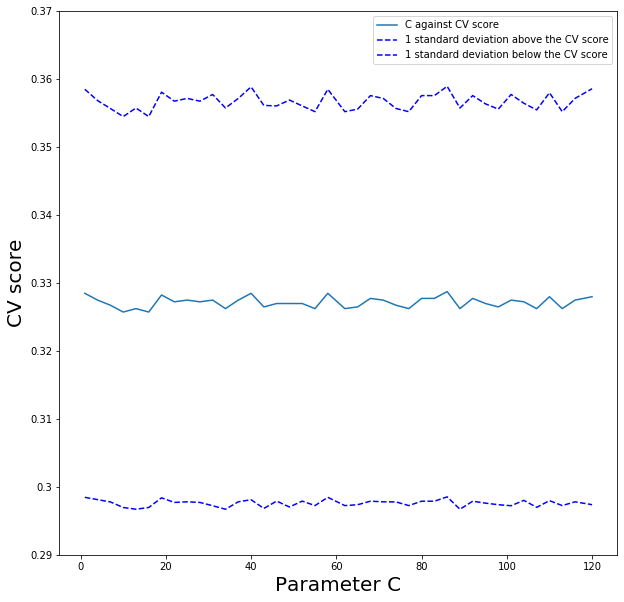

In [0]:
#plot the values of C against the CV score
C_s = clf.cv_results_['param_C'].data
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(C_s, scores, label='C against CV score')
plt.plot(C_s, np.array(scores) + np.array(scores_std), 'b--',label= '1 standard deviation above the CV score')
plt.plot(C_s, np.array(scores) - np.array(scores_std), 'b--', label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter C',fontsize=20)
plt.legend()
plt.show()

Our best value for C is 86 which is quite a high value which will mean a smaller street with fewer margin violations and $\sum_{i=1}^{N}\xi_{i}\leq 86 $ where as before, $\xi_{i}$ represents the proportional of being on the wrong side of the street. Esenatially, the points lie close to each other, which can be concluded as well from the Random Forest Classifier where we have seen from the probabilities that it finds it hard to distinguish between the classes. Moreover, we will move on to the kernel rbf Support Vector Machine Classifier, which by adding similarity features it might help overcome this problem. 

In [0]:
#initialise the final version of the model with hyperparameter chosen
clf_final=SVC(kernel='linear',random_state=42,C=86)
clf_final.fit(X_train,Y_train.values)

SVC(C=86, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

#### Support Vector Machine with kernel RBF

We will model a Support Vector Machine Classifier but we will change the kernel to 'rbf'. The Gaussian RBF kernel has the form $K(a,b)=exp(-\gamma\mid\mid a-b\mid\mid^{2})$. The kernel trick essentially obtains a similar result as you have first added those new features and then performed a linear SVM. The Gaussian RBF adds features using similiarity which calculates how much each instance resembles a particular landmark (b). Usually we select landmarks at the location of each instance. If we would have m instances and n features, we would end up with m features and m instances, thus it can be seen why the kernel trick is useful. 

Here $\gamma$, in simpler terms, is defined as $\frac{1}{2\sigma^{2}}$ where $\sigma^{2}$ is the variance of the kernel. Therefore, $\gamma$ defines the spread of the kernel. For a small $\gamma$, 2 points can be considered similar even if are far from each other and a large $\gamma$ would mean that the points are similiar only if they are close to each other and it will create inslands around the instances.

In [0]:
svmcls2=SVC(kernel='rbf',random_state=42,gamma='scale')#initialise the model; gamma='scale' means that the value of gamma is equal to n_features*X.var()
#and the variance of X for us is 1, thus gamma=6 
C_s=[int(x) for x in np.linspace(1,120,40)]#set up a list of values for C
params2={'C':C_s}#set up a dictionary for GridSearchCV
clf2=GridSearchCV(estimator=svmcls2,param_grid=params2,scoring='accuracy',cv=stf)

In [0]:
#fit GridSearchCV to our data and print the best value for the parameter
clf2.fit(X_train,Y_train.values)
print(clf2.best_params_)

{'C': 1}


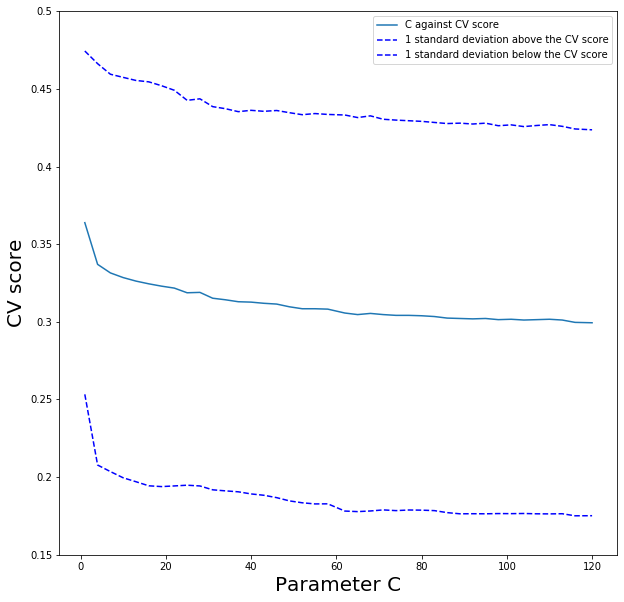

In [0]:
#plot the values of C against the CV score
C= clf2.cv_results_['param_C'].data
scores = clf2.cv_results_['mean_test_score']
scores_std = clf2.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(C, scores,label='C against CV score')
plt.plot(C, np.array(scores) + np.array(scores_std), 'b--',label='1 standard deviation above the CV score')
plt.plot(C, np.array(scores) - np.array(scores_std), 'b--',label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter C',fontsize=20)
plt.legend()
plt.show()

From the GridSearchCV, we can see that the best value is 1, with a peak at that value and then starting to descend and eventually converging. We will run another GridSearch in the area (0.1,2) to see if we can find a better value

In [0]:
C_s2=[round(x,1) for x in np.linspace(0.1,2,20)]#set up a list of values for C
params2={'C':C_s2}#set up a dictionary for GridSearchCV
clf2=GridSearchCV(estimator=svmcls2,param_grid=params2,scoring='accuracy',cv=stf)

In [0]:
#fit GridSearchCV to our data and print the best value for the parameter
clf2.fit(X_train,Y_train.values)
print(clf2.best_params_)

{'C': 0.4}


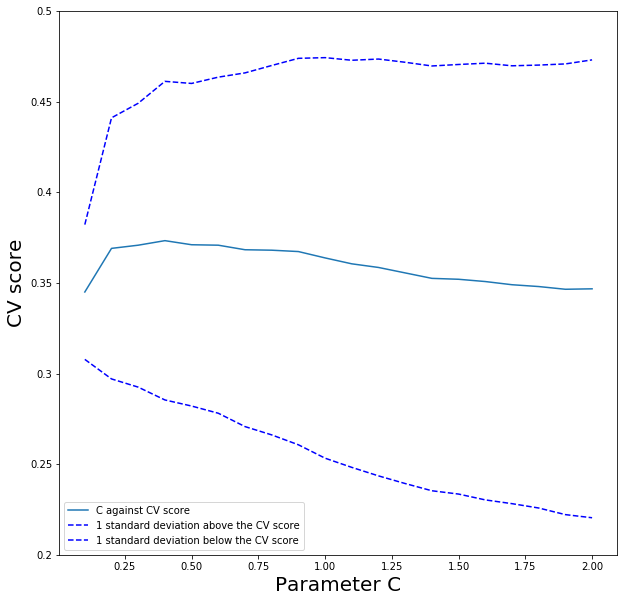

In [0]:
#plot the values of C against the CV score
C= clf2.cv_results_['param_C'].data
scores = clf2.cv_results_['mean_test_score']
scores_std = clf2.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(C, scores,label='C against CV score')
plt.plot(C, np.array(scores) + np.array(scores_std), 'b--',label='1 standard deviation above the CV score')
plt.plot(C, np.array(scores) - np.array(scores_std), 'b--',label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter C',fontsize=20)
plt.legend()
plt.show()

As expected, we have found a better value of C, which is 0.4. As expressed in the Linear SVC case, now using the rbf kernel, we managed to enlarge the street, even if we would have more margin violations. However, the CV score is higher in this case, meaning that even if we have margin violations, they are on the right side of the street. 

In [0]:
svmcls2=SVC(kernel='rbf',random_state=42,C=0.4)#initialise the SVM model with rbf kernel and the best value for C
gamma=[round(x,1) for x in np.linspace(0.01,10,30)]#set up the list of values for gamma
params2={'gamma':gamma}#set up the dictionary for GridSearchCV
clf2=GridSearchCV(estimator=svmcls2,param_grid=params2,scoring='accuracy',cv=stf)

In [0]:
#fit GridSearchCV to the data and print the best value for our parameter
clf2.fit(X_train,Y_train.values)
print(clf2.best_params_)

{'gamma': 0.4}


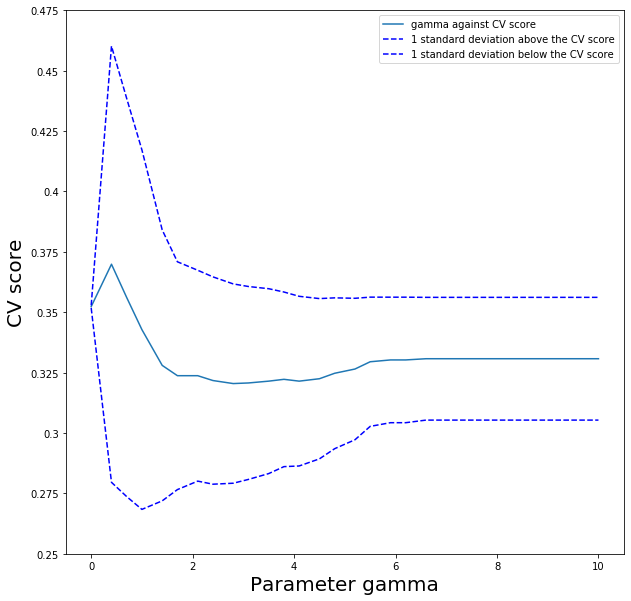

In [0]:
#plot the values of gamma against the CV score
gamma= clf2.cv_results_['param_gamma'].data
scores = clf2.cv_results_['mean_test_score']
scores_std = clf2.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(gamma, scores,label='gamma against CV score')
plt.plot(gamma, np.array(scores) + np.array(scores_std), 'b--',label='1 standard deviation above the CV score')
plt.plot(gamma, np.array(scores) - np.array(scores_std), 'b--',label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter gamma',fontsize=20)
plt.legend()
plt.show()

I would like to investigate again what happens in the region (0,0.4) and see if I can find a better value.

In [0]:
svmcls2=SVC(kernel='rbf',random_state=42,C=0.4)#initialise the SVM model with rbf kernel and the best value for C
gamma=[round(x,2) for x in np.linspace(0,0.4,15)]#set up the list of values for gamma
params2={'gamma':gamma}#set up the dictionary for GridSearchCV
clf2=GridSearchCV(estimator=svmcls2,param_grid=params2,scoring='accuracy',cv=stf)

In [0]:
#fit GridSearchCV to the data and print the best value for our parameter
clf2.fit(X_train,Y_train.values)
print(clf2.best_params_)

{'gamma': 0.17}


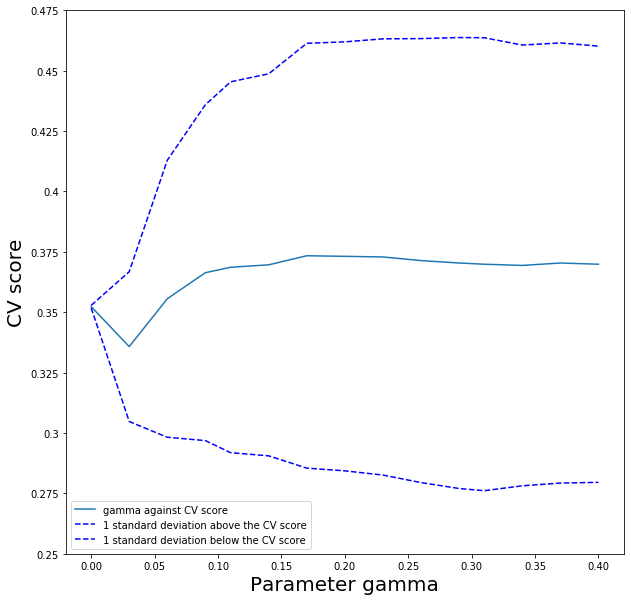

In [0]:
#plot the values of gamma against the CV score
gamma= clf2.cv_results_['param_gamma'].data
scores = clf2.cv_results_['mean_test_score']
scores_std = clf2.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(gamma, scores,label='gamma against CV score')
plt.plot(gamma, np.array(scores) + np.array(scores_std), 'b--',label='1 standard deviation above the CV score')
plt.plot(gamma, np.array(scores) - np.array(scores_std), 'b--',label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter gamma',fontsize=20)
plt.legend()
plt.show()

We have found a better value than 0.4, which 0.17. Now, we can define our final model.

A gamma of value of 0.17, means that the variance of the kernel is 0.34 and points are considered similar even if are far from each other.

In [0]:
#initialise the final version of the model with the hyperparameters chosen so far
clf2_final=SVC(kernel='rbf',random_state=42,gamma=0.17,C=0.4)
clf2_final.fit(X_train,Y_train.values)

SVC(C=0.4, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.17, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

#### Support Vector Machine with polynomial kernel

We will model a Support Vector Machine, but we will change the kernel to 'poly'. The polynomial kernel is defined as $K(a,b)=(\gamma a^{T}b +r)^{d}$. For this model, we will tune d and C where r and d represents the degree of the kernel.

In [0]:
svmcls3=SVC(kernel='poly',random_state=42,gamma='auto')#initialise the model
C=[int(x) for x in np.linspace(1,120,40)]#list of values for C
params3={'C':C}#set up a dictionary for GridSearchCV
clf3=GridSearchCV(estimator=svmcls3,param_grid=params3,scoring='accuracy',cv=stf)

In [0]:
#fit GridSearchCV to the model and print the best value for C
clf3.fit(X_train,Y_train.values)
print(clf3.best_params_)

{'C': 113}


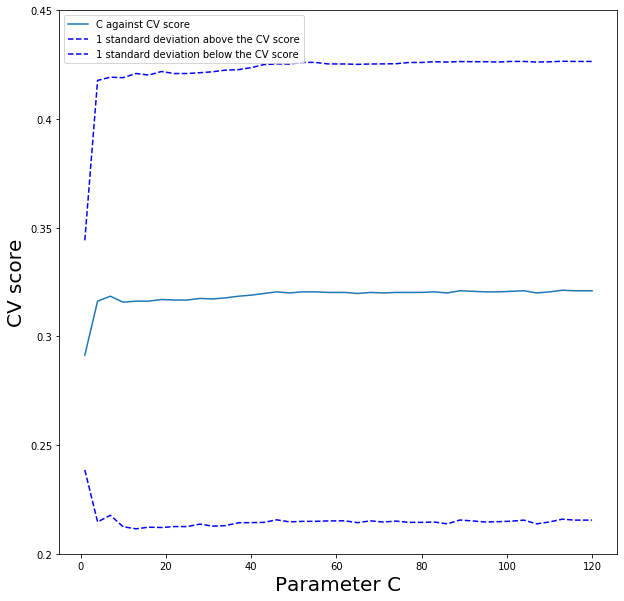

In [0]:
#plot the value of C against the CV score
C= clf3.cv_results_['param_C'].data
scores = clf3.cv_results_['mean_test_score']
scores_std = clf3.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(C, scores,label='C against CV score')
plt.plot(C, np.array(scores) + np.array(scores_std), 'b--',label='1 standard deviation above the CV score')
plt.plot(C, np.array(scores) - np.array(scores_std), 'b--',label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter C',fontsize=20)
plt.legend()
plt.show()

The CV score starts converging to a value of around 0.32 and it does not seem as it will increase if we change the range for C, therefore we will keep this value.

In [0]:
svmcls3=SVC(kernel='poly',random_state=42,gamma='auto',C=113)#initialise the model with the best value of C
degrees=[2,3,4,5,6,7]#list of values for degree
params3={'degree':degrees}#set up dictionary for GridSearchCV
clf3=GridSearchCV(estimator=svmcls3,param_grid=params3,scoring='accuracy',cv=stf)

In [0]:
#fit GridSearchCV to the data and print the best value of the parameter
clf3.fit(X_train,Y_train.values)
print(clf3.best_params_)

{'degree': 3}


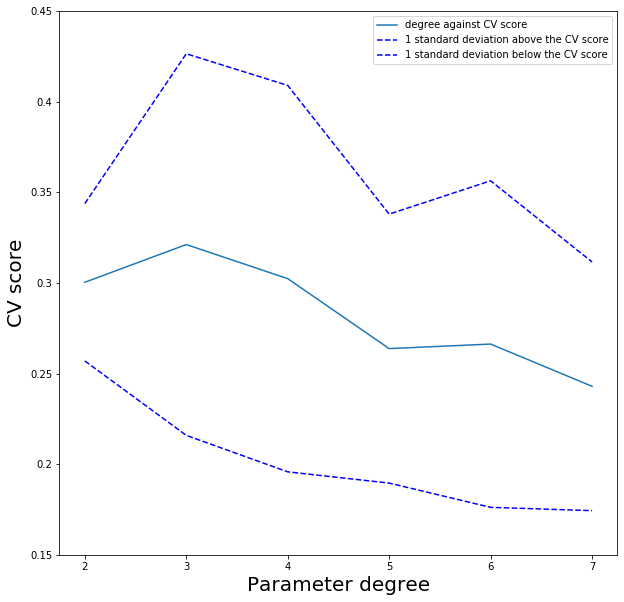

In [0]:
#plot values of degree against the CV scores
degree= clf3.cv_results_['param_degree'].data
scores = clf3.cv_results_['mean_test_score']
scores_std = clf3.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(degree, scores,label='degree against CV score')
plt.plot(degree, np.array(scores) + np.array(scores_std), 'b--', label='1 standard deviation above the CV score')
plt.plot(degree, np.array(scores) - np.array(scores_std), 'b--',label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter degree',fontsize=20)
plt.legend()
plt.show()

The CV score is decaying, therefore we do not need to change the range for degree. 

In [0]:
svmclf3_final=SVC(kernel='poly',random_state=42,gamma='auto',C=113,degree=3)#initialise the model with the best values of C and degree
svmclf3_final.fit(X_train,Y_train.values)

SVC(C=113, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Based on the CV scores and computational time, we will select as our final SVM model, the SVM with kernel rbf.

[back to top](#toc)

#Task 3: Neural Network
<a id='net'></a>

We will implement a feed-forward neural network with 2 hidden layers, each having 200 neurons. We are using the Relu activation function, the optimisation method is Stochastic Gradient Descend and the loss function is cross-entropy. We will train on batches of 24 data points with learning rate of 0.01 for 120 epochs. 

The power of neural networks comes from their ability to learn a mapping. Each neuron will have weights assigned to their inputs plus the bias. Starting with the input layer, we calcualte the wighted sum and then we feed into the activation function, which in our case is Relu. We take the output and then feed it into the next layer and then we continue till we reach the end. At the end we compute the errors between the desired output and the predicted out. We compute how much each of the neurons from the previous layer contributed to the errors and we keep going till we reach the beginning. This is called backpropagation algorithm. Finally, we change the weights to reduce the erros - Gradient Descent. We use the learning rate, to decide how much we are going to update the weights. This means that a learning rate of 0.1, a traditionally common default value, would mean that weights in the network are updated 0.1 * (estimated weight error).
$$w_{i,j}=w_{i,j}+\eta(\hat{y}_{j}-y_{j})x_{i}$$
where $w_{i,j}$ is the connection weight between the input neuron i and ouput neuron j and $\eta$ is the learning rate.

In [0]:
#set up the parameters
input_size = 6
hidden_size = 200
num_classes = 4
num_epochs = 120
batch_size = [64,2,256]
learning_rate = [0.01,0.005,0.95]

In [0]:
#set up the torch tensor that is going to be added into the tensordataset
X_train_2 = torch.from_numpy(X_train).float()
y_train_2 = torch.from_numpy(Y_train.values)
X_test_2 = torch.from_numpy(X_test).float()
y_test_2 = torch.from_numpy(Y_test.values)

In [0]:
#transform into a TensorDataset so we can feed it into the neural network
train = torch.utils.data.TensorDataset(X_train_2, y_train_2)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size[0],shuffle=True)
test = torch.utils.data.TensorDataset(X_test_2, y_test_2)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size[0],shuffle=True)

In [0]:
#initialise the neural network with 2 hidden layers and relu activation function
class NeuralNet(nn.Module):
    def __init__(self, input_size=6, hidden_size=200, num_classes=4):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))#relu activation function 
        out = F.relu(self.fc2(out))#relu activation function
        out = self.fc3(out)
        return out

In [0]:
net = NeuralNet(input_size, hidden_size, num_classes)
#cross-entropy as loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent as optimiser
optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate[0])  

In [0]:
loss_values=[]#list of training loss values
for epoch in range(num_epochs):
      train_loss = 0.0
      net.train()
    ###################
    # train the model #
    ###################
      for data, target in train_loader:
          data = data.reshape(-1, 6)
       
        # clear the gradients of all optimized variables
          optimiser.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
          output = net(data)
        # calculate the loss
          loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
        # perform a single optimization step (parameter update)
          optimiser.step()
        # update running training loss
          train_loss += loss.item()*data.size(0) #data.size(0) is 64
        
    
    # calculate average loss over an epoch
      train_loss = train_loss/len(train_loader.dataset)
      loss_values.append(train_loss)
      
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.360014
Epoch: 2 	Training Loss: 1.331529
Epoch: 3 	Training Loss: 1.318568
Epoch: 4 	Training Loss: 1.309744
Epoch: 5 	Training Loss: 1.303128
Epoch: 6 	Training Loss: 1.298061
Epoch: 7 	Training Loss: 1.294026
Epoch: 8 	Training Loss: 1.290651
Epoch: 9 	Training Loss: 1.288080
Epoch: 10 	Training Loss: 1.285723
Epoch: 11 	Training Loss: 1.283719
Epoch: 12 	Training Loss: 1.281754
Epoch: 13 	Training Loss: 1.280083
Epoch: 14 	Training Loss: 1.278343
Epoch: 15 	Training Loss: 1.276770
Epoch: 16 	Training Loss: 1.275131
Epoch: 17 	Training Loss: 1.273925
Epoch: 18 	Training Loss: 1.272223
Epoch: 19 	Training Loss: 1.270734
Epoch: 20 	Training Loss: 1.269359
Epoch: 21 	Training Loss: 1.267924
Epoch: 22 	Training Loss: 1.266361
Epoch: 23 	Training Loss: 1.265139
Epoch: 24 	Training Loss: 1.263800
Epoch: 25 	Training Loss: 1.262389
Epoch: 26 	Training Loss: 1.260975
Epoch: 27 	Training Loss: 1.259609
Epoch: 28 	Training Loss: 1.258181
Epoch: 29 	Training Loss: 1.2

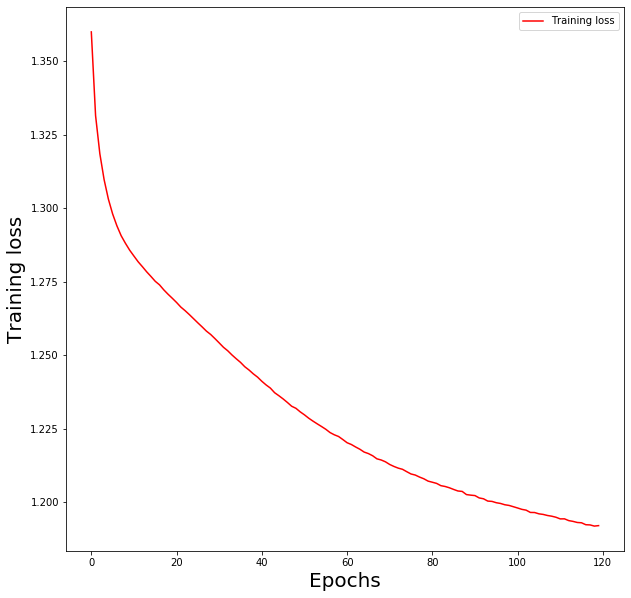

In [0]:
plt.figure(figsize=(10,10))
plt.plot(loss_values,label='Training loss',color='r')
plt.ylabel('Training loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.legend()

As we can see, the training loss converges, geting closer to 1.

## Task 3.1

We will now investigate how changing the learning rate to 0.0005 and 0.95 will lead to poor convergence.

In [0]:
loss_values_dict2={}
for m in range(len(learning_rate)):
    loss_values2=[]
    net = NeuralNet(input_size, hidden_size, num_classes)
    optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate[m])
    X_train_2 = torch.from_numpy(X_train).float()
    y_train_2 = torch.from_numpy(Y_train.values)  
    train = torch.utils.data.TensorDataset(X_train_2, y_train_2)
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size[0],shuffle=True)
    for epoch in range(num_epochs):
         
          train_loss = 0.0
          net.train()
    ###################
    # train the model #
    ###################
          for data, target in train_loader:
              data = data.reshape(-1, 6)
       
        # clear the gradients of all optimized variables
              optimiser.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
              output = net(data)
        # calculate the loss
              loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
              loss.backward()
        # perform a single optimization step (parameter update)
              optimiser.step()
        # update running training loss
              train_loss += loss.item()*data.size(0) #data.size(0) is 64
        
    
    # calculate average loss over an epoch
          train_loss = train_loss/len(train_loader.dataset)
          loss_values2.append(train_loss)
          
    loss_values_dict2.update({'learning_rate '+str(m):loss_values2})
    print('Finished trainig for ' +str(m))

  

Finished trainig for 0
Finished trainig for 1
Finished trainig for 2


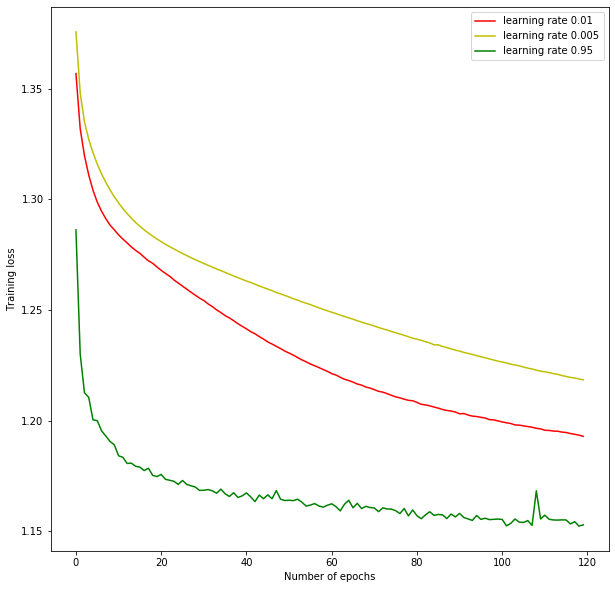

In [0]:
plt.figure(figsize=(10,10))
plt.plot(loss_values_dict2['learning_rate 0'],color='r',label='learning rate 0.01')
plt.plot(loss_values_dict2['learning_rate 1'],color='y',label='learning rate 0.005')
plt.plot(loss_values_dict2['learning_rate 2'],color='g',label='learning rate 0.95')
plt.xlabel('Number of epochs')
plt.ylabel('Training loss')
plt.legend()

As it can be seen from the formula, a learning rate that is too high will result in weight updates that are too large and will cause the training loss that oscillates as it can be seen from the green line. A learning rate that is too small, on the other hand will result in weight updates that are too small and that will never converge and find the suboptimal solution. As it can be seen from the yellor and red line, when setting the learning rate to 0.01 we manage to find a better minimum and faster. Stochastic Gradient Descend picks a random instance and computes the gradient and therefore by the setting the learning rate too high we will assume that every instances behaves the same and thus the oscillations.

I believe another factor that contributes is the ReLu activation which for negative instances the gradient will be 0 and the weights will not be adjusted.

## Task 3.2

We will investigate now how changing the batch size to 2 and 256 leads to poor convergence and performance.

In [0]:
loss_values_dict1={}
for m in range(len(batch_size)):
    loss_values1=[]
    net = NeuralNet(input_size, hidden_size, num_classes)
    optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate[0]) 
    X_train_2 = torch.from_numpy(X_train).float()
    y_train_2 = torch.from_numpy(Y_train.values) 
    train = torch.utils.data.TensorDataset(X_train_2, y_train_2)
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size[m],shuffle=True)
    for epoch in range(num_epochs):
        
          train_loss = 0.0
          net.train()
    ###################
    # train the model #
    ###################
          for data, target in train_loader:
              data = data.reshape(-1, 6)
       
        # clear the gradients of all optimized variables
              optimiser.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
              output = net(data)
        # calculate the loss
              loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
              loss.backward()
        # perform a single optimization step (parameter update)
              optimiser.step()
        # update running training loss
              train_loss += loss.item()*data.size(0) #data.size(0) is 64
        
    
    # calculate average loss over an epoch
          train_loss = train_loss/len(train_loader.dataset)
          loss_values1.append(train_loss)
          
    loss_values_dict1.update({'batch size '+str(m):loss_values1})
    print('Finished training for '+str(m))


Finished training for 0
Finished training for 1
Finished training for 2


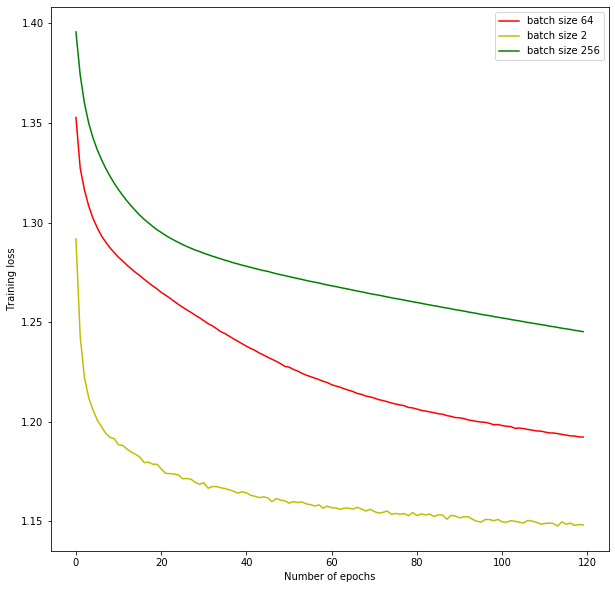

In [0]:
plt.figure(figsize=(10,10))
plt.plot(loss_values_dict1['batch size 0'],color='r',label='batch size 64')
plt.plot(loss_values_dict1['batch size 1'],color='y',label='batch size 2')
plt.plot(loss_values_dict1['batch size 2'],color='g',label='batch size 256')
plt.xlabel('Number of epochs')
plt.ylabel('Training loss')
plt.legend()


The first thing to notice is that by changing the batch size to 2, the training time increased. That is essentially that we would have more iterations to go through in each epoch and it is faster to make use of the linear algebra functions for fewer iterations that to go through all the loops. Given a batch size of 256, it will even learn the mistakes and it will not be able to generalise on new instances. A neural network learns better when it is shown different things. 

# Task 3.3

We are going to introduce a dropout regularisation to the second layer of the neural network. It will randomly deactivate neurons at each training step. By doing so, we can construct an ensemble of neural networks with different architectures. The weights associated with each neuron get updated only p fraction of time. 

In [0]:
class NeuralNet2(nn.Module):
    def __init__(self, input_size=6, hidden_size=200, num_classes=4, p_s=0.5):
        super(NeuralNet2, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout=nn.Dropout(p_s)
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out=  self.dropout(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [0]:
net2 = NeuralNetClassifier(
    module=NeuralNet2,
    max_epochs=120,
    lr=0.01,
    batch_size=64)

In [0]:
p_s=[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
params={'module__p_s':p_s}
search=GridSearchCV(estimator=net2,param_grid=params,scoring='accuracy',cv=stf)

In [0]:
search.fit(X_train.astype(np.float32),Y_train.values.astype(np.int64))
print(search.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.3521           nan  0.0941
      2           nan       0.3521           nan  0.0899
      3           nan       0.3521           nan  0.0939
      4           nan       0.3521           nan  0.1025
      5           nan       0.3521           nan  0.0950
      6           nan       0.3521           nan  0.0913
      7           nan       0.3521           nan  0.0915
      8           nan       0.3521           nan  0.0986
      9           nan       0.3521           nan  0.0910
     10           nan       0.3521           nan  0.0911
     11           nan       0.3521           nan  0.0914
     12           nan       0.3521           nan  0.0914
     13           nan       0.3521           nan  0.1010
     14           nan       0.3521           nan  0.0938
     15           nan       0.3521           nan  0.0911
     16           nan       0.3

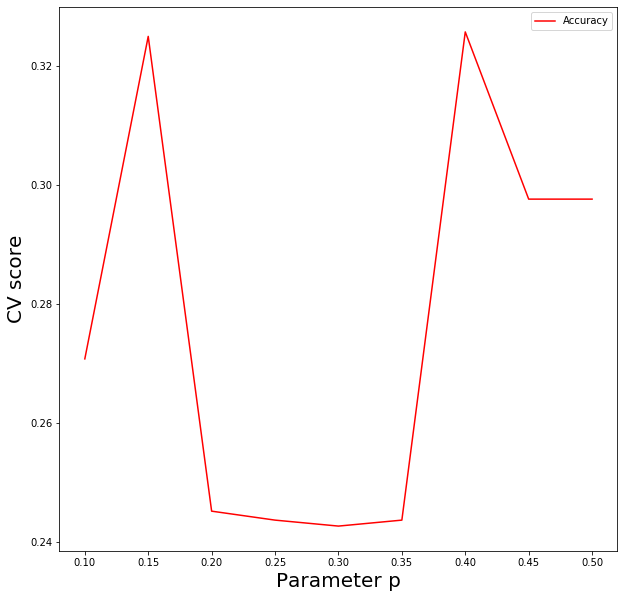

In [0]:
p_values= search.cv_results_['param_module__p_s'].data
scores = search.cv_results_['mean_test_score']
plt.figure(figsize=(10,10))
plt.plot(p_values, scores,label='Accuracy',color='r')
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter p',fontsize=20)
plt.legend()
plt.show()

In [0]:
loss_values3=[]
for epoch in range(num_epochs):
      # monitor training loss
      train_loss = 0.0
      net3 = NeuralNet2(input_size, hidden_size, num_classes,p_s=0.4)
      optimiser = torch.optim.SGD(net3.parameters(), lr=learning_rate[0])
      X_train_2 = torch.from_numpy(X_train).float()
      y_train_2 = torch.from_numpy(Y_train.values)
      train = torch.utils.data.TensorDataset(X_train_2, y_train_2)
      train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size[m],shuffle=True)
      net3.train()
    ###################
    # train the model #
    ###################
      for data, target in train_loader:
          data = data.reshape(-1, 6)
       
        # clear the gradients of all optimized variables
          optimiser.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
          output = net(data)
        # calculate the loss
          loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
        # perform a single optimization step (parameter update)
          optimiser.step()
        # update running training loss
          train_loss += loss.item()*data.size(0) #data.size(0) is 64
        
    # print training statistics 
    # calculate average loss over an epoch
      train_loss = train_loss/len(train_loader.dataset)
      loss_values3.append(train_loss)
      
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.244763
Epoch: 2 	Training Loss: 1.244764
Epoch: 3 	Training Loss: 1.244764
Epoch: 4 	Training Loss: 1.244763
Epoch: 5 	Training Loss: 1.244764
Epoch: 6 	Training Loss: 1.244763
Epoch: 7 	Training Loss: 1.244763
Epoch: 8 	Training Loss: 1.244763
Epoch: 9 	Training Loss: 1.244763
Epoch: 10 	Training Loss: 1.244763
Epoch: 11 	Training Loss: 1.244763
Epoch: 12 	Training Loss: 1.244763
Epoch: 13 	Training Loss: 1.244763
Epoch: 14 	Training Loss: 1.244763
Epoch: 15 	Training Loss: 1.244764
Epoch: 16 	Training Loss: 1.244763
Epoch: 17 	Training Loss: 1.244763
Epoch: 18 	Training Loss: 1.244764
Epoch: 19 	Training Loss: 1.244764
Epoch: 20 	Training Loss: 1.244763
Epoch: 21 	Training Loss: 1.244763
Epoch: 22 	Training Loss: 1.244764
Epoch: 23 	Training Loss: 1.244764
Epoch: 24 	Training Loss: 1.244763
Epoch: 25 	Training Loss: 1.244763
Epoch: 26 	Training Loss: 1.244763
Epoch: 27 	Training Loss: 1.244763
Epoch: 28 	Training Loss: 1.244763
Epoch: 29 	Training Loss: 1.2

[back to top](#toc)

# Task 4: Discussions
<a id='dis'></a>

## Task 4.1

In [0]:
net3.eval()
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
correct = 0
total = 0
for images, labels in test_loader:
    images = images.reshape(-1, 6)
    labels = labels
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels.data).squeeze()
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    for i in range(4):
        label = labels.data[i]
        class_correct[label] += c[i]
        class_total[label] += 1
for i in range(4):
        print('Accuracy of {} : {} / {} = {:.4f} %'.format(i, 
class_correct[i], class_total[i], 100 * class_correct[i].item() / 
class_total[i]))           
print('Accuracy of the network: {} %'.format(100 * correct / total))

Accuracy of 0 : 18.0 / 23.0 = 78.2609 %
Accuracy of 1 : 3.0 / 16.0 = 18.7500 %
Accuracy of 2 : 5.0 / 14.0 = 35.7143 %
Accuracy of 3 : 5.0 / 11.0 = 45.4545 %
Accuracy of the network: 55.74596774193548 %


The neural network has the lowest accuracy of all the model tried. The accuracy for the class 'unacc' is the highest as in the other models. In this case, however, the accuracy for the class 'acc' is the lowest even compared to the other models. I believe that we didn't have enough features and data so that the neural network can learn general patterns. As seeen in the random forest classifier, we only have 3 main features that contribute to the performance of the models.

In [0]:
pred1=rfmodel_final.predict(X_test)
print(classification_report(Y_test.values,pred1))
print('Accuracy score is ' + str(accuracy_score(Y_test.values,pred1)*100))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       412
           1       0.49      0.24      0.33       188
           2       0.45      0.50      0.47       204
           3       0.51      0.59      0.54       188

    accuracy                           0.59       992
   macro avg       0.54      0.53      0.53       992
weighted avg       0.58      0.59      0.58       992

Accuracy score is 59.375


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f84eae17fd0>)

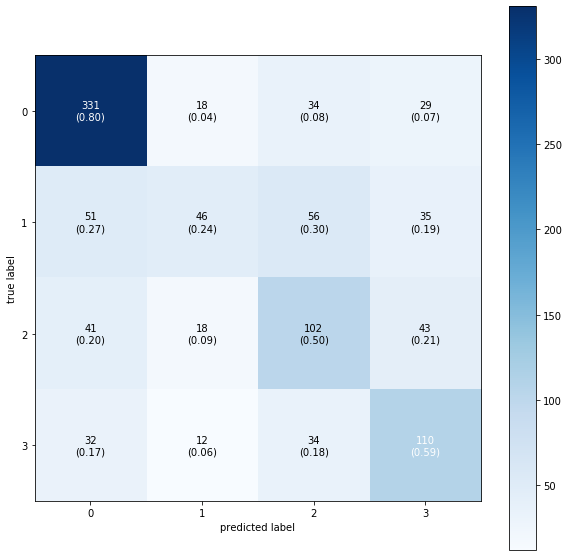

In [0]:
conf_max1=confusion_matrix(Y_test.values, pred1)
plot_confusion_matrix(conf_mat=conf_max1, show_absolute=True, show_normed=True, colorbar=True, figsize=[10,10])

As expected the precision and recall for the class 0, 'unacc', are high. We are precised when deciding that an instance belongs to this class and we can also remember and recognise most of the real class 0 instances. 

For class 1, 'acc', we have a precision of almost 0.5 which is alright, however, we tend to also asign instances from class 'acc' to 'unacc' and 'good'. 

For class 2, we are less precised than in class 0 and 1, but we have a higher recall than class 1 which goes back to the trade off between precision and recall. If we increase the precision, the recall will decrease. Then, we need to decide which is more important in our project.  We have some instances misclassified as being 'unacc' and 'vgood'.  
Class 3 is performing better than class 1 and class 2, having higher precision and recall overall. As in class 2, we have some instances that are misclassified as being 'unacc' and 'good'.

Compared to the CV score we had, I believe that the model is not overfitting.



In [0]:
pred2=clf2_final.predict(X_test)
print(classification_report(Y_test.values,pred2))
print('Accuracy score is ' + str(accuracy_score(Y_test.values,pred2)*100))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       412
           1       0.54      0.28      0.36       188
           2       0.47      0.52      0.50       204
           3       0.54      0.58      0.56       188

    accuracy                           0.61       992
   macro avg       0.57      0.55      0.55       992
weighted avg       0.60      0.61      0.60       992

Accuracy score is 61.18951612903226


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f84ead8b208>)

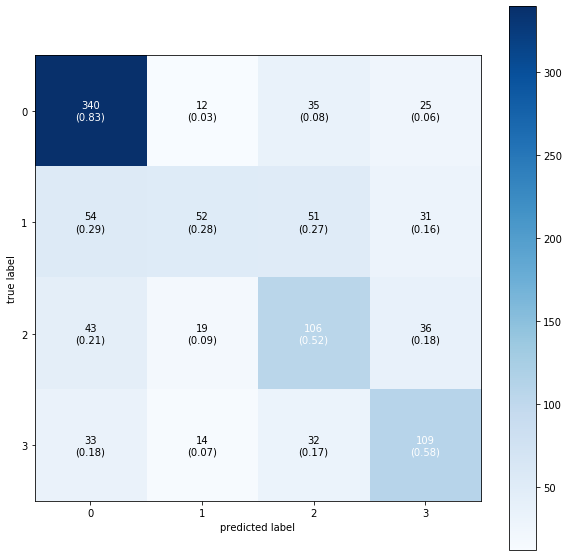

In [0]:
conf_max2=confusion_matrix(Y_test.values, pred2)
plot_confusion_matrix(conf_mat=conf_max2, show_absolute=True, show_normed=True, colorbar=True, figsize=[10,10])

Support Vector Machine with 'rbf' kernel performs better than Random Forest Classifier in general. Again, for class 0, the precision and recall are high with just a few misclassified as being from this class. 

For class 1, we have again a low recall, majority being misclassified as being from 'unacc' or 'good'. For class 2, we have a higher recall with majority being misclassified as being 'unacc' and 'vgood'. We have a lower precision that in class 1 with having instances from class 'acc' and 'vgood' misclassified as 'good'. For class 3, we have instances from this class misclassified as being 'unacc' and 'good' and as well. 

Compared to the CV score we had, I believe that we are not overfitting.

## Task 4.2

Comparing the accuracy, precision and recall of the models, the best candidate is Support Vector Machine Classifier with kernel 'rbf'. Given the dimensionality of the data, even if the training time is the lowest, I believe that neural networks it is not suitable for our problem. We might consider using a kernel approximation function such us Nystroem method and then train a neural network as we have seen that the 'rbf' kernel helps differentiate better between the classes. For all the models, we are not overfitting and we manage to generalise. In terms of computational cost, the Support Vector Machine Classifier might get expensive when increasing the number of instances, however we might be able to overcome this by firstly doing a kernel approximation and then training a linearSVC which trains much faster. 

Finnally, the model that we have selected is Support Vector Machine Classifier with kernel 'rbf'. I am going to make a change to the model and perform a GridSearchCV again, mainly to overcome the inbalanced classes. I am going to set the 'class_weight' to balanced. And we can see how the precision and recall for class 1 increases. 


In [0]:
svmcls4=SVC(kernel='rbf',random_state=42,gamma='scale',class_weight='balanced')
C_s2=[round(x,2) for x in np.linspace(0.01,0.4,15)]#set up a list of values for C
params2={'C':C_s2}#set up a dictionary for GridSearchCV
clf4=GridSearchCV(estimator=svmcls4,param_grid=params2,scoring='accuracy',cv=stf)

In [0]:
#fit GridSearchCV to our data and print the best value for the parameter
clf4.fit(X_train,Y_train.values)
print(clf4.best_params_)

{'C': 0.09}


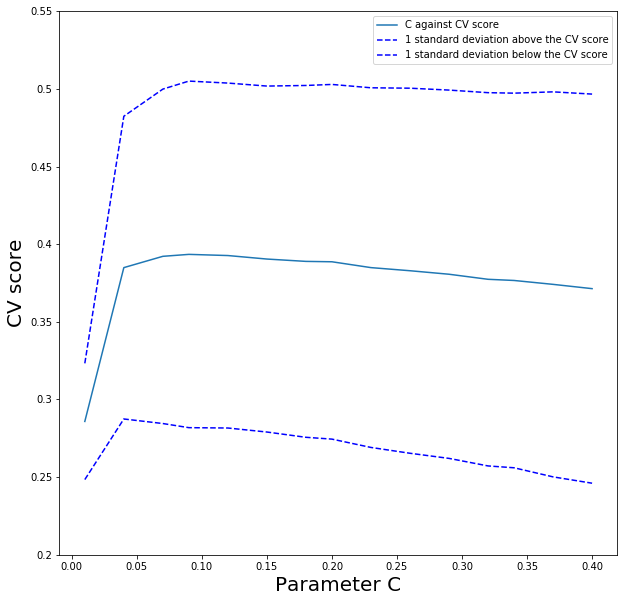

In [0]:
C= clf4.cv_results_['param_C'].data
scores = clf4.cv_results_['mean_test_score']
scores_std = clf4.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(C, scores,label='C against CV score')
plt.plot(C, np.array(scores) + np.array(scores_std), 'b--',label='1 standard deviation above the CV score')
plt.plot(C, np.array(scores) - np.array(scores_std), 'b--',label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter C',fontsize=20)
plt.legend()
plt.show()

In [0]:
svmcls4=SVC(kernel='rbf',random_state=42,C=0.09,class_weight='balanced')#initialise the SVM model with rbf kernel and the best value for C
gamma=[round(x,2) for x in np.linspace(0,0.4,15)]#set up the list of values for gamma
params2={'gamma':gamma}#set up the dictionary for GridSearchCV
clf4=GridSearchCV(estimator=svmcls4,param_grid=params2,scoring='accuracy',cv=stf)

In [0]:
#fit GridSearchCV to the data and print the best value for our parameter
clf4.fit(X_train,Y_train.values)
print(clf4.best_params_)

{'gamma': 0.37}


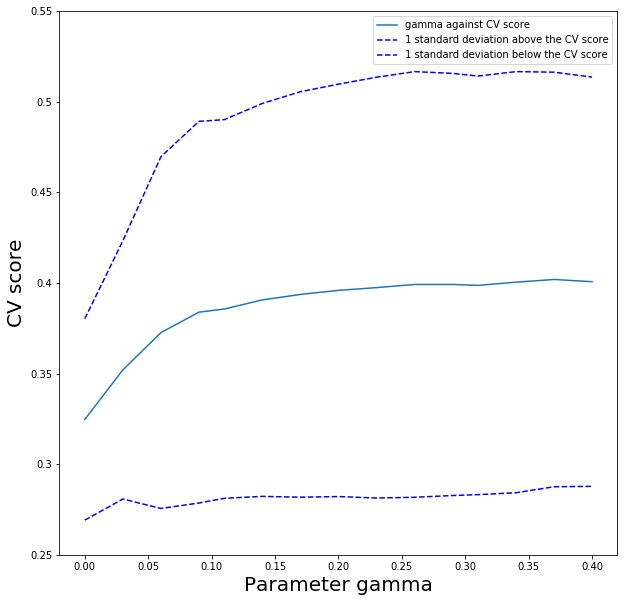

In [0]:
#plot the values of gamma against the CV score
gamma= clf4.cv_results_['param_gamma'].data
scores = clf4.cv_results_['mean_test_score']
scores_std = clf4.cv_results_['std_test_score']
plt.figure(figsize=(10,10))
plt.plot(gamma, scores,label='gamma against CV score')
plt.plot(gamma, np.array(scores) + np.array(scores_std), 'b--',label='1 standard deviation above the CV score')
plt.plot(gamma, np.array(scores) - np.array(scores_std), 'b--',label='1 standard deviation below the CV score')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score',fontsize=20)
plt.xlabel('Parameter gamma',fontsize=20)
plt.legend()
plt.show()

In [0]:
#initialise the final version of the model with the hyperparameters chosen so far
clf2_final1=SVC(kernel='rbf',random_state=42,gamma=0.37,C=0.09,class_weight='balanced')
clf2_final1.fit(X_train,Y_train.values)

SVC(C=0.09, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.37, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
pred3=clf2_final1.predict(X_test)
print(classification_report(Y_test.values,pred3))
print('Accuracy score is ' + str(accuracy_score(Y_test.values,pred3)*100))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       412
           1       0.47      0.47      0.47       188
           2       0.47      0.51      0.49       204
           3       0.55      0.57      0.56       188

    accuracy                           0.62       992
   macro avg       0.58      0.58      0.58       992
weighted avg       0.63      0.62      0.62       992

Accuracy score is 61.89516129032258


[back to top](#toc)